In [16]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import random
import time

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import ColumnTransformer

data = pd.read_csv("data/X_train.csv")

In [2]:
data.shape

(1285000, 14)

In [3]:
data.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [4]:
##data.index vai buscar todos os indexes da tabela em que o booleano é vdd
# print(type(data['t']))  ## data['t'] vai buscar todos os valores da coluna t, precedidios do seu index desde o 0
# print(data["t"])        usamos o [1] no final para ir buscar a SEGUNDA instância de t=0
# print()                 isto devolve 257 porque t=0 volta a ocorrer na linha 258 cujo index é 257
# print("________________________________")

# print("this is for displaying some data on the data")

def analysis():
    #display("data description table: ", data.describe(include='all'))
    #display("number of null entries: ", data.isnull().sum().sum())
    display("these are the min and max values for x1 and y1: ", data[['x_1', 'y_1']].agg(['min', 'max']))
    display("these are the min and max values for x2 and y2: ", data[['x_2', 'y_2']].agg(['min', 'max']))
    display("these are the min and max values for x3 and y3: ", data[['x_3', 'y_3']].agg(['min', 'max']))
    display("correlation to y1 for each variable is: ",data.corr()['y_1'])

def visualize(): #desatualizada
    ax = locked_df.plot(kind='line', x='x_1', y='y_1', label='(x1,y1)')
    locked_df.plot(kind='line', x='x_2', y='y_2', ax=ax, label='(x2,y2)')
    locked_df.plot(kind='line', x='x_3', y='y_3', ax=ax, label='(x3,y3)')
    px.scatter_matrix(data, dimensions=["t", "x_1", "y_1"])
    print("this is the current trajectory")
    plt.show()

#analysis()
#visualize()


## data splits

In [ ]:


def detect_collision_route(strt, end):
    route = data.iloc[strt:end] # define os limites da trajetória
    #print(route)
    for row in route.itertuples():  # por cada linha nessa trajetória verifica se está a zeros
        if (row.x_1 == 0) and (row.x_2 == 0) and (row.x_3 == 0) and (row.t == 0):
            return [row.Index+3, True]     # se há colisão então guarda todas as linhas até à colisão E também três linhas a zeros (para o modelo dps pder prever colisões)
    #print("collision is working properly!")
    return [row.Index, False]


def route_split():
    col_routes = []
    clean_routes = []
    for i in data.index[data["x_1"] == 1]: # por cada index inicial de uma trajetória
        #print("index : ", i)
        info = detect_collision_route(i,i+258)  # verifica se essa trajet+oria tem colisão
        if info[1] == True:
            col_routes.append(data.iloc[i:info[0]])    # dps distribui. divide as colisões das n colisões
        else:
            clean_routes.append(data.iloc[i:info[0]])
    #print(col_routes[0])
    #print(clean_routes[0])
    return col_routes, clean_routes  # retorna as listas das trajetórias
            

col_routes, clean_routes = route_split()
random.shuffle(col_routes)
random.shuffle(clean_routes)
# EM FALTA: verificar se há trajetórias duplicadas através de hashing
"""
total = len(data.index[data["x_1"] == 1])  #estes prints estão desatualizados porque estão a usar len e não shape
print("total number os routes: ", total)
print("number of colisions: ", len(col_routes))
print("number of clean slates: ", len(clean_routes))
print("calculated total: ", len(col_routes)+len(clean_routes))
print("percentage of colisions :", (len(col_routes)*100)/total)
print("percentage of cleans :", (len(clean_routes)*100)/total)
"""

def data_split(n):
    trainSet=[]
    validSet=[]
    testSet=[]
    samples=0
    ratio=0
    test_samples=0
    test_ratio=0
    while samples <= int(n*0.81):             ## estou a adicionar o racio certo (81%) de trajetorias sem colisão
        trainSet.append(clean_routes.pop(0))
        samples = samples+1
    while ratio <= int(n*0.19):               ## estou a adicionar o racio certo (19%) de trajetorias com colisão
        trainSet.append(col_routes.pop(0))
        ratio = ratio+1
    while test_samples <= int(n*0.243):       # estou a criar os sets de validacao e teste com 30% do tamanho do train
        validSet.append(clean_routes.pop(0))  # mas tambem quero manter o racio certo de colisões e não colisões
        testSet.append(clean_routes.pop(0))   # é dai que vem o 0.243(81%) e o 0.057(19%) pois 0.243+0.057=0.3 o tamanho desejado
        test_samples = test_samples+1
    while test_ratio <= int(n*0.057):
        validSet.append(col_routes.pop(0))
        testSet.append(col_routes.pop(0))
        test_ratio = test_ratio+1

    return pd.concat([df for df in trainSet], ignore_index=True).drop('Id', axis=1), \
           pd.concat([df for df in validSet], ignore_index=True).drop('Id', axis=1),\
           pd.concat([df for df in testSet], ignore_index=True).drop('Id', axis=1) #passa tudo para um df outra vez e tiro a coluna Id que é inutil

trainSet, validSet, testSet = data_split(2000)  # escolho arbitrariamente o nmr de samples para o trainSet e o tamanho dos outros é deduzido
                                                # a partir daí
                                    
#print(testSet)

def target_split(data):  # isto cria dois sets, x e y
    x = data.iloc[:-1].copy()  # o set x tem a linha 0 até a penultima linha
    y = data.iloc[1:].copy()   # o set y tem a linha 1 ate a ultima linha
    x = x.reset_index(drop=True)
    y = y.reset_index(drop=True)
    y = y.drop(['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3'], axis=1) #livramonos das velocidades, não as queremos prever
    x = x[x.columns[1:].tolist() + [x.columns[0]]] # meter a coluna do tempo em ultimo
    y = y[y.columns[1:].tolist() + [y.columns[0]]] 
    return xtrain, ytrain

X_train, y_train = target_split(trainSet)
#print(X_train.head())
#print(y_train.head())
X_valid, y_valid = target_split(validSet)
X_test, y_test = target_split(testSet)
#print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)


# Model

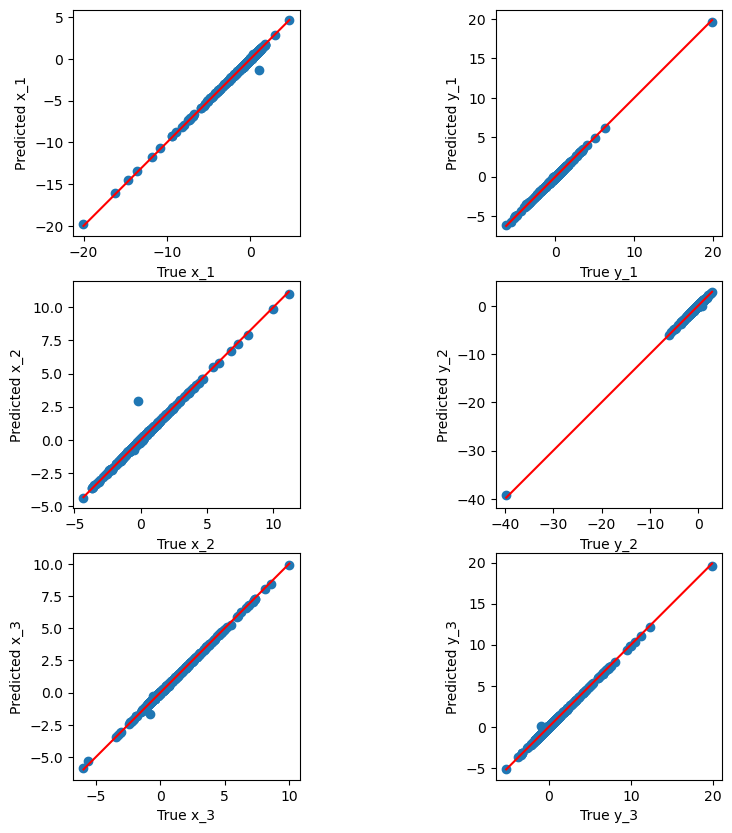

mean squared error:  0.08109570371783095


In [33]:
ppl = make_pipeline(StandardScaler(), LinearRegression())
lm = TransformedTargetRegressor(regressor=ppl, transformer=StandardScaler())
lm.fit(X_train, y_train)
preds = lm.predict(X_valid)

def plot_y_yhat(y_test,y_pred, plot_title = "plot"): # função que a stora deu para ver as previsões, mas passa tudo pa numpy arrays
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 1000

    if isinstance(y_test, (pd.DataFrame, pd.Series)):
        y_test = y_test.to_numpy()

    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
        y_pred = y_pred.to_numpy()

    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
        #print("a",idx.shape)
    else:
        idx = np.arange(len(y_test))
        #print("b",idx.shape)
    plt.figure(figsize=(10,10))
    #return idx
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()


#print(y_valid.shape, preds.shape)
plot_y_yhat(y_valid, preds, "plot")
 
print('mean squared error: ', mean_squared_error(y_valid, preds))



# git status  (ver as mudanças)
# git add .   (adicionar tudo o que está a vermelho no status)
# git commit -m "message" (envia para o repositório local)
# git push origin main (envia as mudanças para o repositótrio remoto)


In [ ]:
#### input will be x = matriz cujas linhas são valores numa certa timestamp (shuffled)
#### também teremos uma matriz y cujas linhas são a resposta correspondente da timestanmp em x

#### isto é: se a linha 4 da matriz x corresponde à timestamp k, então a linha 4 da matriz y deve ser a timestamp
#### imediata correspondete. deve ser o que o modelo deve prever. damos lhe as duas matrizes de padrões do 
#### próximo passo e queremos que ele aprenda aquilo
#### we split the train data by TRAJECTORIES
#### never use the test set during training



# Data Exploration

### Limpar os dados ( ver se há valores nulos, missing values, se sim como tratà-los ?)
#### Ver se há outliers, o que fazer com eles, ver a distribuiçoes etc
#### ver correlaçoes ( neste caso nao faz sentio porque só tens uma var explicativa por previsao)

# Feature engineering

### Ver escalas (faz sentido normalizar os dados ? o tempo e o X1 estão na mm escala ? )
### Criar vars polinomiais, por exemplo (t^2X ou X^2)

# Model training

#### Divides os dados de treino em treino e validaçao (80/20) verificar se há overfitting 
#### Que tipo de problema é ? em ML tens 2 grandes : -classifivcaçao e regressao
#### Que métricas vais usar ? A tu a prf fala em RMSE 
### Que modelo vais usar ?
### Ler resultados

